In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import sys
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, LSTM
from keras.regularizers import l1, l2, l1_l2


module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.transformers import LinearTransformation, ParabolicTransformation, TrigTransformation

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Global Var
sliding_window_size = 20

Using TensorFlow backend.


In [2]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

In [3]:
def chunk_data(data, number_of_chunks):
    chunks = list()
    lst = np.linspace(0, len(data), number_of_chunks + 1, dtype = int)
    for start, stop in zip(lst[0:-1], lst[1:]):
        chunks.append(data[start:stop].copy())
    return chunks

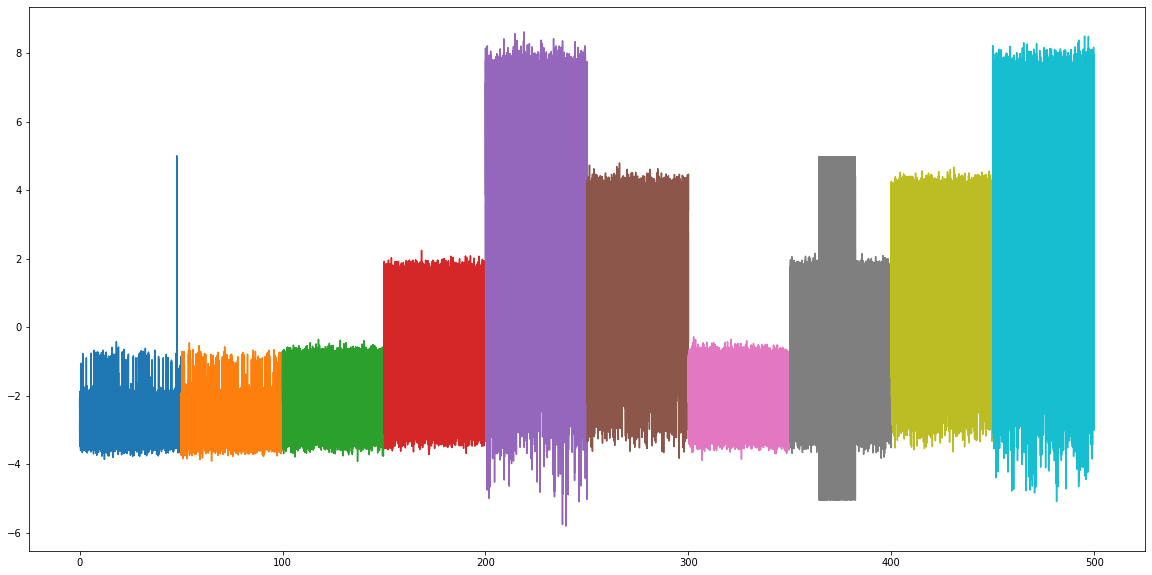

In [4]:
train_chunks = chunk_data(full_data, 10)

lt = LinearTransformation()
pt = ParabolicTransformation()
tt = TrigTransformation(trig_function = 'sin')

train_chunks[1].loc[train_chunks[1].index[:100000], 'signal'] = lt.fit_transform(train_chunks[1][:100000], 3/10, -15)
train_chunks[6]['signal'] = tt.fit_transform(train_chunks[6], 300, 50, 4.95)
train_chunks[7]['signal'] = tt.fit_transform(train_chunks[7], 350, 50, 5.030)
train_chunks[8]['signal'] = tt.fit_transform(train_chunks[8], 400, 50, 4.974)
train_chunks[9]['signal'] = tt.fit_transform(train_chunks[9], 450, 50, 5.089)

plt.figure(figsize = (20, 10))
for i in train_chunks:
    plt.plot(i['time'], i['signal'])

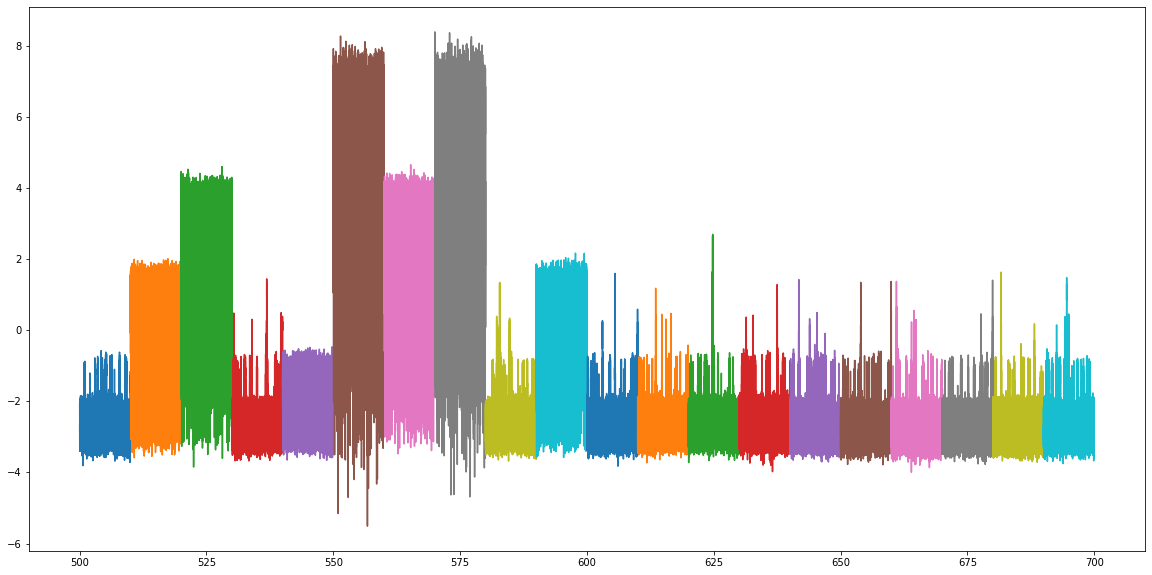

In [5]:
test_chunks = chunk_data(test_data, 4)
test_chunks = chunk_data(test_chunks[0], 5) + chunk_data(test_chunks[1], 5) + test_chunks[2:]

test_chunks[0]['signal'] = lt.fit_transform(test_chunks[0], 3 / 10, -150)
test_chunks[1]['signal'] = lt.fit_transform(test_chunks[1], 3 / 10, -153)
test_chunks[4]['signal'] = lt.fit_transform(test_chunks[4], 3 / 10, -162)
test_chunks[6]['signal'] = lt.fit_transform(test_chunks[6], 3 / 10, -168)
test_chunks[7]['signal'] = lt.fit_transform(test_chunks[7], 3 / 10, -171)
test_chunks[8]['signal'] = lt.fit_transform(test_chunks[8], 3 / 10, -174)
test_chunks[10]['signal'] = tt.fit_transform(test_chunks[10], 600, 50, 4.925)

test_chunks = test_chunks[:10] + chunk_data(pd.concat(test_chunks[10:]), 10)

plt.figure(figsize = (20, 10))
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

In [6]:
def _sliding_window(array, window_size, offset = 0):
    """
    offset = number of zeros added to the begining 
    """
    array = np.append(np.append(np.zeros(offset), array), np.zeros(window_size - offset))
    sliding_window_array = [array[0: -window_size]]
    for i in range(1, window_size):
        sliding_window_array = np.append(sliding_window_array, [array[i:i - window_size]], axis = 0)
    return sliding_window_array.T

def make_sliding_window(series, window_size):
    col_names = [series.name + str(i) for i in range(window_size)]
    return pd.DataFrame(_sliding_window(series, window_size, window_size // 2), columns = col_names)

def make_sliding_window_frame(data, window_size):
    sliding_window = make_sliding_window(data['signal'], window_size)
    sliding_window['open_channels'] = data['open_channels'].reset_index(drop = True)
    return sliding_window

In [11]:
def _model_architecture():
    model = Sequential()
    model.add(Dense(22, input_dim = sliding_window_size, activation = 'relu'))
    model.add(Dense(33, activation = 'relu'))
    model.add(Dense(44, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def _train_model(model, data, cycles = 5, epochs = 3):
    for _ in range(cycles):
        time.sleep(5)
        y = data['open_channels']
        X = data.drop(['open_channels'], axis = 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35)
        model.fit(X_train, y_train, batch_size = 100, epochs = epochs, validation_data = (X_test, y_test))

        
#'''
def get_model(data, train_model = True, cycles = 5, epochs = 3):
    model = _model_architecture()
    if train_model:
        _train_model(model, data, cycles = cycles, epochs = epochs)
    return model
#'''

'''
def get_model(data, time_window_size):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                         input_shape=(time_window_size, 1)))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Dense(units = time_window_size, activation='linear'))
    model.add(Dense(time_window_size * 2, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
#'''

'''
def get_modelx(data, time_window_size):
    model = Sequential()
    model.add(LSTM(time_window_size * 10, input_shape  = (1, time_window_size)))
    model.add(Dense(40, activation = 'relu', kernel_regularizer = l2(0.01)))
    model.add(Dense(11, activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
#''';

In [12]:
#model = get_model(model5_data, cycles = 20, epochs = 2)

y = model5_data['open_channels']
X = model5_data.drop(['open_channels'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35)
model.fit(X_train, y_train, batch_size = 100, epochs = 3, validation_data = (X_test, y_test))

y = model5_data['open_channels']
X = model5_data.drop(['open_channels'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train, batch_size = 100, epochs = 3, validation_data = (X_test, y_test))

In [13]:
model1_data = pd.concat([train_chunks[0], train_chunks[1]])
model1_data = make_sliding_window_frame(model1_data, sliding_window_size)

model2_data = pd.concat([train_chunks[2], train_chunks[6]])
model2_data = make_sliding_window_frame(model2_data, sliding_window_size)

model3_data = pd.concat([train_chunks[3]])
# model3_data = pd.concat([train_chunks[3], train_chunks[7]])
model3_data = make_sliding_window_frame(model3_data, sliding_window_size)

model4_data = pd.concat([train_chunks[5], train_chunks[8]])
model4_data = make_sliding_window_frame(model4_data, sliding_window_size)

model5_data = pd.concat([train_chunks[4], train_chunks[9]])
model5_data = make_sliding_window_frame(model5_data, sliding_window_size)

In [15]:
model1 = get_model(model1_data, cycles = 8, epochs = 2)
print('\n\n')
time.sleep(300)
model2 = get_model(model2_data, cycles = 8, epochs = 2)
print('\n\n')
time.sleep(300)
model3 = get_model(model3_data, cycles = 10, epochs = 2)
print('\n\n')
time.sleep(300)
model4 = get_model(model4_data, cycles = 15, epochs = 2)
print('\n\n')
time.sleep(300)
model5 = get_model(model5_data, cycles = 20, epochs = 2)

Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0166 - accuracy: 0.9945 - val_loss: 0.0046 - val_accuracy: 0.9986
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0109 - val_accuracy: 0.9963
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 8s 12us/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0020 - val_accuracy: 0.9993
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0019 - val_accuracy: 0.9995
Train on 650000 samples, validate on 350000 samples
Epoch 1/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 2/2
650000/650000 [==============================] - 7s 11us/step - loss: 0.0019 - accuracy: 0.999

In [16]:
def predict(model, test_data):
    y_predictions = model.predict_classes(make_sliding_window(test_data['signal'], sliding_window_size))
    return pd.DataFrame({'time' : test_data['time'].values, 'open_channels' : y_predictions})

In [17]:
predictions = pd.DataFrame(columns = ['time', 'open_channels'])
predictions = pd.concat([predictions, predict(model1, test_chunks[0])])
predictions = pd.concat([predictions, predict(model3, test_chunks[1])])
predictions = pd.concat([predictions, predict(model4, test_chunks[2])])
predictions = pd.concat([predictions, predict(model1, test_chunks[3])])
predictions = pd.concat([predictions, predict(model2, test_chunks[4])])
predictions = pd.concat([predictions, predict(model5, test_chunks[5])])
predictions = pd.concat([predictions, predict(model4, test_chunks[6])])
predictions = pd.concat([predictions, predict(model5, test_chunks[7])])
predictions = pd.concat([predictions, predict(model1, test_chunks[8])])
predictions = pd.concat([predictions, predict(model3, test_chunks[9])])
predictions = pd.concat([predictions, predict(model1, test_chunks[10])])
predictions = pd.concat([predictions, predict(model1, test_chunks[11])])
predictions = pd.concat([predictions, predict(model1, test_chunks[12])])
predictions = pd.concat([predictions, predict(model1, test_chunks[13])])
predictions = pd.concat([predictions, predict(model1, test_chunks[14])])
predictions = pd.concat([predictions, predict(model1, test_chunks[15])])
predictions = pd.concat([predictions, predict(model1, test_chunks[16])])
predictions = pd.concat([predictions, predict(model1, test_chunks[17])])
predictions = pd.concat([predictions, predict(model1, test_chunks[18])])
predictions = pd.concat([predictions, predict(model1, test_chunks[19])])

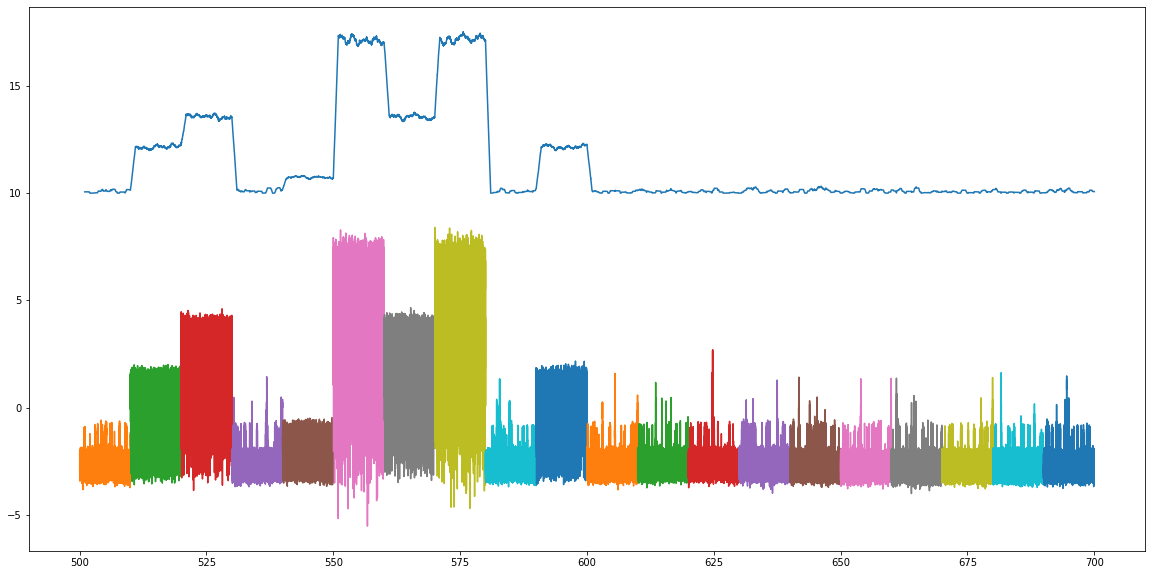

In [18]:
plt.figure(figsize = (20, 10))
plt.plot(predictions['time'], predictions['open_channels'].rolling(10000).mean() + 10)
for i in test_chunks:
    plt.plot(i['time'], i['signal'])

In [19]:
predictions.to_csv('~/Desktop/test_predictions2.csv', index = False, float_format='%.4f')
#0.937 preds_12